In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt

from jupyterthemes.stylefx import set_nb_theme


set_nb_theme('gruvboxd')

# 07 Pytorch Expriment Tracking 

Machine Learning is very exprimental. 

In Order to figure out which expriments are worth pursuing, that's were expreiment tracking come in it helps youto figure out what dooes wordk



In [2]:
import torch 
import torchvision 

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


In [3]:
import matplotlib.pyplot as plt 
import torch
import torchvision
from torch import nn 
from torchvision import transforms 


try:
    from torchinfo import summary 
    
except:
    print("[INFO couldn't find torchinfo.. installing it.]")
    !pip install -1 torchinfo
    from torchinfo import summary 
    
    

In [4]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find going_modular scripts... downloading them from GitHub.


fatal: destination path 'pytorch-deep-learning' already exists and is not an empty directory.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'going_modular'

In [5]:
# setup device angnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# set seed 
def set_seeds(seed:int=42):
    
    # set the seed for general torch operations 
    torch.manual_seed(seed)
    
    # set the seed for cuda torch operation 
    torch.cuda.manual_seed(seed)

In [7]:
set_seeds

<function __main__.set_seeds(seed: int = 42)>

## 1. Get data 

want to get pizza, steak, sushi images. 

so we can run experiments building foodvision Mini and see which model performs best.

In [8]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [9]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [10]:
# !rm -rf data/  # remove the everything the data 

### 2. create Datasets and DataLoaders 

#### 2.1 Create DataLoaders with manual transforms 

The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a
way that suit pretend model

In [11]:
# setup the directories 
train_dir = image_path / "train"
test_dir = image_path / "test"


train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [12]:
# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [13]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [14]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir, 
    transform = manual_transforms,
    batch_size=32
    

)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2583f7ce790>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms 

The same principle applies for autmatic transforms: we want our custom data in the same format as the 
    pretrained model was tranied on
    https://pytorch.org/vision/master/models.html

In [15]:
# setup dirs 
train_dir = image_path / "train"
test_dir = image_path / "test"


# Setup pretrained weights (plenty of these weights available in torchvision.models)
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT   # default = best abailable 

# get transforms from weights (these  are the transforms used to train a particular or obtain  a particular set of weights)
automatic_transforms = weights.transforms()
print(f"automatic created transforms: {automatic_transforms}")


# create DataLoader 
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, 
                                                                  test_dir=test_dir, 
                                                                  transform=automatic_transforms,
                                                                  batch_size=32)

train_dataloader, test_dataloader, class_names


automatic created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x2583f8f4400>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a  pretrained model, freeze the base layers and change the classifier head 

In [16]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model
# View the output of the model
# model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
# Freeze all base layers by setting their requires_grad attribute to False 
for param in model.features.parameters():
#     print(param)
    param.requires_grad = False

In [18]:
# Adjust the classifier head 
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
from torchinfo import summary
summary(model,
       input_size=(32, 3, 224,224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train a single model and track results 





In [21]:
# define loss function optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track expriment, we are going to use TensorBoard: https://www.tensorflow.org/tensorboard/
        
And to interact with TensorBoard, we can use PyTorch summaryWriter - https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

* Also see here - https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter


In [22]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()
writer

In [23]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment Tracking ###
        # see summarywriter documentation
        writer.add_scalars(main_tag = "Loss",
                          tag_scalar_dict={"train_loss":train_loss,
                                          "test_loss":test_loss},
                          global_step=epoch)
        
        
        writer.add_scalars(main_tag="Accuracy",
                          tag_scalar_dict={"train_acc":train_acc,
                                         "train_loss":test_acc},
                          global_step=epoch)
        
        writer.add_graph(model=model,
                        input_to_model=torch.randn(32,3,224,224).to(device))
        
        #close the writer
        writer.close
        
        ## End New ##
        
        

    # Return the filled results at the end of the epochs
    return results

In [24]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [25]:
# train model 
set_seeds()
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer = optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device
               )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1009 | train_acc: 0.3711 | test_loss: 0.9242 | test_acc: 0.5805
Epoch: 2 | train_loss: 0.9155 | train_acc: 0.6641 | test_loss: 0.8132 | test_acc: 0.7036
Epoch: 3 | train_loss: 0.7957 | train_acc: 0.7344 | test_loss: 0.6750 | test_acc: 0.8958
Epoch: 4 | train_loss: 0.6674 | train_acc: 0.8398 | test_loss: 0.6749 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6932 | train_acc: 0.7148 | test_loss: 0.6926 | test_acc: 0.7216


## 5. view our model's results with tensorboard

In [26]:
# LEt's view our expreiment form with the notebook
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 17136), started 1 day, 18:12:07 ago. (Use '!kill 17136' to kill it.)

## 6. create a function to prepare summarywriter instance 

By default our summarywriter() class save to log_dir.

How about if we wanted to save diff experiment to diff folder 

In essence, one expreiment = one folder 

for example , we had like to track:
* Experiment date/timestamp
* Expriment name
* Model name 
* Extra - is there anything else that should be tracked?

Let's create a function to create a SummaryWriter instance to take all of these things into account. 

So ideally we end up tracking expriments to a directory:

runs/YYYY-MM-DD/expriment_name/model_name/extra 

In [27]:
from torch.utils.tensorboard import SummaryWriter


def create_writer(experiment_name:str,
                 model_name=str,
                 extra:str=None,
                 ):
    
    """Create a torch.utils.tensorboard.writer.summaryWriter() instance tracking to a spacific directory"""
    from datetime import datetime 
    import os 
    
    # get timestamp of current date in reverse order 
    temestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        # create log directory path 
        log_dir = os.path.join("runs",temestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs",temestamp, experiment_name, model_name)
        print(f"[INFO] created summaryWriter saving to {log_dir}")
        
        
    
    return SummaryWriter(log_dir=log_dir)

In [28]:
# from datetime import datetime
# datetime.now()

In [29]:
# temestamp = datetime.now().strftime("%Y-%m-%d")
# temestamp

In [30]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb0",
                              extra="5_epochs")
example_writer

### 6.1 Update the 'train()' function to include a writer parameter

In [31]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer:torch.utils.tensorboard.writer.SummaryWriter  # new parameter to take in a writer
         ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment Tracking ###
        if writer:
            # see summarywriter documentation
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict={"train_loss":train_loss,
                                              "test_loss":test_loss},
                              global_step=epoch)


            writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc":train_acc,
                                             "train_loss":test_acc},
                              global_step=epoch)

            writer.add_graph(model=model,
                            input_to_model=torch.randn(32,3,224,224).to(device))

            #close the writer
            writer.close
            
        else:
            pass 
        
        ## End New ##
        
        

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments


* Challenge: Setup 2x modelling experiments with effnetb0, pizza, steak, sushi data and train one model for 5 epochs and another model for 10 epochs 

### 7.1 What kind of experiments should you run ?

The number of machine learning experiments you can run is like the numberof different models you can build.. almost limitless.

However, you can't test evrything..
so what should you test?
* change the number of epochs 
* change the number of hidden layers/units
* changae the amount of data (right now we are using 10% of the food101 dataset for pizza, steak, sushi)
* chanage the learning rate 
* Try different kinds of data augmentation
* choose a different model architecture 


THis is why transfer learning is so pawerful, because it is a working model that you can apply to your own problem.


### 7.2 what experiments are we going to run?

we are going to turn three dials:
1. Model size - EffnetB0 vs EffnetB2  (in terms of number of parematers)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
3. Training time  - 5 epochs vs 10 epochs - 5 epochs vs 10 epochs (generally longer training time = better results , up to a point)


To begin, we are still keping things relatively small so that our experiments run quickly. 


our goal : a model that is well performing but still small enough to run on a mobile device or web browser, so foodvision mini can come to life.

If you had infinite compute + time , you should basically always choose the biggest model and biggest dataset you can. 




### 7.3 Download different datasets 

we want two datasets:
1. Pizzaa, steak, sushi -  10%
2. Pizza, steak, sushi - 20% 

In [32]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


### 7.4 Transform datasets and create dataloaders

we will transform our data in a few ways:
    
1. Resize the image to (224, 224)
2. make sure image tensor values are between [0,1]
3. Normalize the image so they have the same data distribution as ImageNet

In [33]:
# setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"


# setup test directory 
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir 

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [34]:
from torchvision import transforms 

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]



# compose transforms into a pipeline 
simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [35]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [36]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 create feature extractor models

1.torchvision.models.efficientnet_b0() pretrained backbone + custom classifier head (EffNetB0 for short).
2.torchvision.models.efficientnet_b2() pretrained backbone + custom classifier head (EffNetB2 for short).



In [37]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [38]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [39]:
# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [40]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [41]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [42]:
# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [43]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.5 create experiments and set up training code 


In [44]:
# create epoch list 

num_epochs = [5,10]

# create model list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# create a DataLoaders dictionary
train_dataloaders = {"data_10_percent":train_dataloader_10_percent,
                    "data_20_percent":train_dataloader_20_percent}



In [45]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [46]:
%%time

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.5586 | test_loss: 0.8404 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8284 | train_acc: 0.6914 | test_loss: 0.7337 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7219 | train_acc: 0.7578 | test_loss: 0.6268 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8867 | test_loss: 0.5945 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9089 | train_acc: 0.6406 | test_loss: 0.9073 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8453 | train_acc: 0.6797 | test_loss: 0.8130 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7203 | train_acc: 0.8516 | test_loss: 0.6988 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7273 | train_acc: 0.7461 | test_loss: 0.6509 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.9417 | train_acc: 0.5586 | test_loss: 0.8404 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.8284 | train_acc: 0.6914 | test_loss: 0.7337 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7219 | train_acc: 0.7578 | test_loss: 0.6268 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8867 | test_loss: 0.5945 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.5470 | train_acc: 0.8750 | test_loss: 0.6072 | test_acc: 0.8258
Epoch: 7 | train_loss: 0.6481 | train_acc: 0.7227 | test_loss: 0.6107 | test_acc: 0.8258
Epoch: 8 | train_loss: 0.5016 | train_acc: 0.9180 | test_loss: 0.5529 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4611 | train_acc: 0.8945 | test_loss: 0.5422 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.5681 | train_acc: 0.7539 | test_loss: 0.4906 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9089 | train_acc: 0.6406 | test_loss: 0.9073 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8453 | train_acc: 0.6797 | test_loss: 0.8130 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7203 | train_acc: 0.8516 | test_loss: 0.6988 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7273 | train_acc: 0.7461 | test_loss: 0.6509 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6089 | train_acc: 0.7656 | test_loss: 0.6575 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5998 | train_acc: 0.8164 | test_loss: 0.6047 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5486 | train_acc: 0.8281 | test_loss: 0.6058 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5174 | train_acc: 0.7891 | test_loss: 0.5693 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.5073 | train_acc: 0.8203 | test_loss: 0.5605 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5733 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5837 | train_acc: 0.8375 | test_loss: 0.4959 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4558 | train_acc: 0.8938 | test_loss: 0.4131 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8958 | test_loss: 0.3820 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7180 | train_acc: 0.7937 | test_loss: 0.6591 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5576 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8354 | test_loss: 0.5136 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4485 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7022 | train_acc: 0.8063 | test_loss: 0.5733 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5837 | train_acc: 0.8375 | test_loss: 0.4959 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4558 | train_acc: 0.8938 | test_loss: 0.4131 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4514 | train_acc: 0.8958 | test_loss: 0.3820 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4222 | train_acc: 0.8604 | test_loss: 0.3729 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3849 | train_acc: 0.8583 | test_loss: 0.3362 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3451 | train_acc: 0.8938 | test_loss: 0.3427 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3723 | train_acc: 0.8917 | test_loss: 0.3383 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3593 | train_acc: 0.8938 | test_loss: 0.2789 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7767 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7180 | train_acc: 0.7937 | test_loss: 0.6591 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.5791 | train_acc: 0.8771 | test_loss: 0.5576 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5310 | train_acc: 0.8354 | test_loss: 0.5136 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4890 | train_acc: 0.8625 | test_loss: 0.4485 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3795 | train_acc: 0.9125 | test_loss: 0.4643 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3519 | train_acc: 0.9313 | test_loss: 0.4162 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3214 | train_acc: 0.9333 | test_loss: 0.4128 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3428 | train_acc: 0.8896 | test_loss: 0.4318 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3791 | train_acc: 0.8604 | test_loss: 0.3736 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [48]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17136), started 1 day, 18:28:06 ago. (Use '!kill 17136' to kill it.)

# 9. Load in the best model and make predictions with it 

In [49]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [50]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [52]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


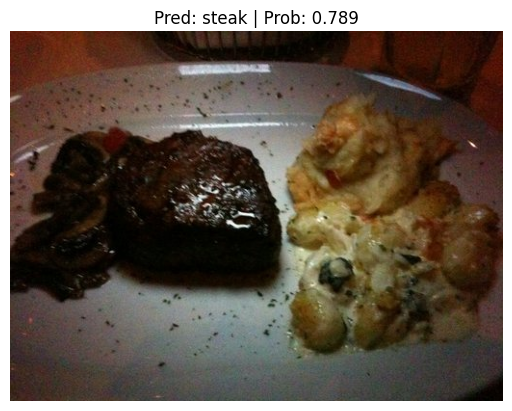

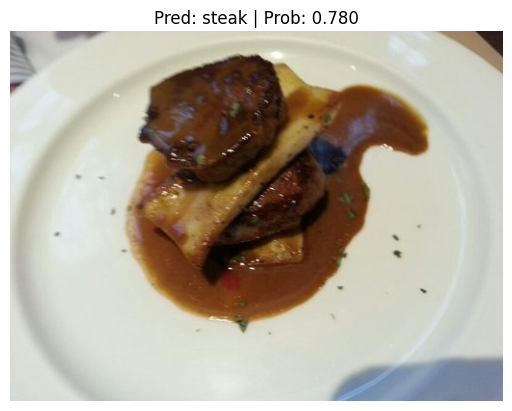

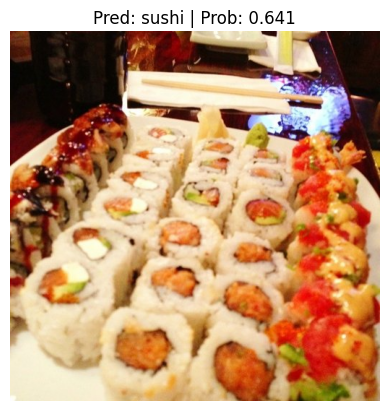

In [55]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
# from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

# 9.1 Pridict on a custom with the best model

data\04-pizza-dad.jpeg already exists, skipping download.


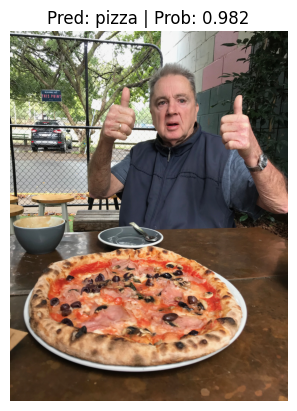

In [56]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)